In [654]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sklearn
import scipy
import os
import re
import timeit

from scipy import stats
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# Methods to import data

#### Methods To Import Event Data

In [433]:
'''
this function will take as an argument a file containing
the field index and description for every field in the data frames.
I will use this to create a template dataframe and to name the columns
because currently it is just using the first value as the column name
and it makes literally no sense at all.
'''
def shape_ev_data():
    #this file contains all the field descriptions
    field_descriptor_file_path = "csvFieldDescriptions.txt"
    
    #open the file and read it, adding each description to a list
    fields = open(field_descriptor_file_path, 'r')
    fieldInfo = []
    for field in fields:
        fieldInfo.append(field[2:].strip())
    fields.close() #close file
    return fieldInfo

In [434]:
'''
This function takes as an argument the number of subframes to include
where each 'subframe' is a pandas data frame containing play by play
data for a team for a year. It will then return those subframes
concatenated together into one main data frame. Subframes is preset to 50
'''
def get_event_data(subframes=50):
    csvFiles = '../data/event_csv_files/'
    csv_paths = os.listdir(csvFiles)#Get the paths of all of the CSV files
    column_info = shape_ev_data()#get the information on each field
    data = pd.DataFrame(columns=column_info)#create an empty data frame
    individual_data = []#create a list to hold the smaller frames
    del individual_data[:]#clear the list just in case I've already been using it

    #make all the dataframes
    df = pd.DataFrame(columns=column_info) #define a temp frame
    for index, path in enumerate(csv_paths):#iterate over the list of paths
        #names=column_info is what names the columns
        df = pd.read_csv(str(csvFiles+path), names=column_info)#read a file into a csv
        individual_data.append(df)#add it to the list
        
        #this line here is what limits how much data you pull.
        #if you eneter -1 for subframes it'll skip this check and
        #generate all of the data
        if(subframes != -1):#if the passed parameter is -1, generate ALL data
            if(index==subframes):#stop when desired subframe # is reached
                break
    
    data = pd.concat(individual_data) #combining sub frames
    del individual_data[:] #dont wanna waste space
    return data#, individual_data

#### Method To Import Game Log Data

In [435]:
#reading in all the game logs and appending the dataframe accordingly
def get_gl_data():
    GLData = pd.DataFrame()
    gls = [] #to hold smaller frames
    del gls[:] #clear it to be sure
    glogpath = '../data/GameLogs/' #path to the game logs
    headPath = glogpath+'game_log_header.csv' #get the column info
    header = pd.read_csv(headPath) #import the column info
    colInfo = header.columns #store it for later use
    start_year = 1950 #define starting year. gonna use this in path
    end_year = 17 #also for path
    for logFolder in os.listdir(glogpath):
        try:#catching non int cases
            y1 = int(logFolder[2:4]) ##first two of start yyyy
            y2 = int(logFolder[2:6]) ##full start year
            y3 = int(str(y1)+logFolder[-2:]) #full end year
        except:
            continue
        #now open the folder if the start year is between the dates in the name
        if(start_year<y3):
            newPath = glogpath+logFolder
            files = os.listdir(newPath)#get all the logs in the folder
            for file in files:#now check each file to make sure it's the righ year
                year = int(file[2:6])#get year of file
                if(year>=start_year):#if it's within the range we want
                    full_path = glogpath+logFolder+'/'+file #make full path
                    gls.append(pd.read_csv(full_path, names=colInfo))#append the frame
    GLData = pd.concat(gls) #combine the subframes into this one
    del gls[:] #not wasting space
    return GLData

#### Method To Import Park Information Data

In [436]:
#this method will return an unedited dataframe of the park information
def get_park_data():
    parks = pd.DataFrame() #create empty frame
    path = '../data/ParkInfo/ParkCodes.TXT' #path to park data

    cols = ['PARKID','CITY','STATE'] #cols to import
    parks = pd.read_csv(path, usecols=cols) #import it as csv
    parks.columns = ['parkid','city','state'] #name cols
    parks['location'] = parks.city + ', ' + parks.state #easier to cross ref
    parks = parks.drop(['city','state'],axis=1)
    
    #parks['lat'] = 0
    #parks['lng'] = 0
    
    return parks #return

#### Method To Import City Data

In [510]:
#this method imports data on cities in the us
def get_ct_data():
    cities = pd.DataFrame() #create empty frame
    path = '../data/ParkInfo/uscities.csv' #path
    
    #which columns to import
    cols = ['city','state_id','lat','lng',]
    
    #get park info but only read the cols i want
    cities = pd.read_csv(path, usecols=cols)
    
    #renaming a couple special cases
    cities.city = cities.city.apply(lambda x: x.replace('Saint','St.'))
    
    cities.columns = ['city','state','lat','lng'] #rename cols
    cities['location'] = cities.city + ', ' + cities.state #for cross ref
    cities = cities.drop(['city','state'], axis=1) #drop old cols
    
    #cities = cities.drop_duplicates(subset='location') #only one station per city
    
    return cities

#### Method To Import Station Data


In [438]:
#imports the station data
def get_st_data():
    cols = ['id','lat','lng','elevation','state']
    stations = pd.DataFrame(columns=cols) #stations
    path = '../data/Weather/station_list.txt' #path to file
    formatted_path = '../data/Weather/formatted_station_list.txt'
    stations = open(path, 'r') #open weather stations
    f_stations = open(formatted_path,'w') #file to write to
    
    #reformat the weather station file so it's not this ridiculous format
    for line in stations: #for each line
        new = line[:41] #remove the end because that's all irrelevant
        new = re.sub('\s\s$', 'zz', new)#fake state col if it doesn't exist
        new = ','.join(new.split())#remove spaces and replace with commas
        new = new+'\n' #add a newline at the end
        f_stations.write(new) #write the formatted line
    f_stations.close() #close the file at the end
    
    #now set stations frame
    stations = pd.read_csv(formatted_path, names=cols)
    
    stations = stations.replace('zz',np.nan)#replace the zz
    print(stations.shape)
    stations = stations.dropna(subset=['state'],axis=0)#drop ones with state (not in us)
    
    return stations

#### Method To Import bgame Files

In [439]:
#get cols of feature names for bgame files
def shape_gl_data():
    fn = open('bgameFeatureNames.TXT', 'r') #open file
    fnames = [] #to store names
    for feature in fn: #go over lines
        f = re.sub('[\(\[].*?[\)\]]', '', feature[5:]).strip() #strip it
        fnames.append(f) #add to list
    fn.close()#close file
    return fnames 

In [440]:
#gets game log data from bgame
def get_gl2_data():
    csvFiles = '../data/game_csv_files/'
    csv_paths = os.listdir(csvFiles)#Get the paths of all of the CSV files
    column_info = shape_gl_data()#get the information on each field
    data = pd.DataFrame(columns=column_info)#create an empty data frame
    individual_data = []#create a list to hold the smaller frames
    del individual_data[:]#clear the list just in case I've already been using it

    #make all the dataframes
    df = pd.DataFrame(columns=column_info) #define a temp frame
    for index, path in enumerate(csv_paths):#iterate over the list of paths
        #names=column_info is what names the columns
        df = pd.read_csv(str(csvFiles+path), names=column_info)#read a file into a csv
        individual_data.append(df)#add it to the list
    
    data = pd.concat(individual_data) #combining sub frames
    del individual_data[:] #dont wanna waste space
    return data#, individual_data

#### Methods To Import Daily Weather Data

In [679]:
#this function will create a dataframe with weather data for the parks that exist
def get_weather_data(parks):
    
    #metadata for fwf import
    first_widths = [11,4,2,4] #widths of metadata
    first_cols = ['id','year','month','element'] #names of metadata
    daily_widths = [5,1,1,1] #widths of data for each day
    daily_cols = ['value','mflag','qflag','sflag'] #names of data for each day
    widths = first_widths #set widths of first columns
    colNames = first_cols #column names array
    drop = [] #actual array of columns to drop

    #iterate over the days of the month
    for i in range(31): 
        temp = [] #to hold the names temporarily
        for col in daily_cols: #now go through these
            temp.append(col+str(i+1)) #just add the proper number to the end of each
        colNames+=temp #add the colnames to name them
        drop+=temp[1:] #drop all but first daily col which is the value
        first_widths+=daily_widths #iteratively adding widths for fwf file
    
    #cols to use
    useCols = list(set(colNames)-set(drop)) #these are the cols i'll use
    
    #basically going to loop and iteratively generate file paths
    #and import only the files i need so i don't have to deal with billions of
    #lines of data
    path = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/STATIONID.dly'
    
    #this will be the real time intensive task. Apply function applied to each
    #row that returns a dataframe of weather for the given station. This frame
    #is then appended to the individualdata frame
    print('Getting weather data...')
    individual_data = [] #create a list to hold the smaller frames
    already_loaded = []
    del individual_data[:] #clear the list just in case
    for n in range(parks.shape[0]):#for each park
        st = parks.station.iloc[n] #get station of park
        
        #has this weather station already been loaded in?
        if st in already_loaded:
            #print("Data for "+st+" has already been loaded!")
            continue
        #for my own sanity
        #print("Getting data for "+st)
        
        #create a temp df
        df = pd.read_fwf(path.replace('STATIONID',st), delim_whitespace=True, widths=widths, names=colNames, usecols=useCols)
        
        #add it to the list
        individual_data.append(df) #append data
        already_loaded.append(st) #mark that this station has been loaded

    #now add them all together and delete the temp list to free space
    data = pd.concat(individual_data) #combine the subframes into this one
    del individual_data[:] #not wasting space
    
    #replace missing -9999 convention with Nan
    data.replace(-9999,np.nan, inplace=True)
    
    return data

# Data Preprocessing

Should probably turn these into functions so I can also preprocess the main dataset. or any of the data that I want to pass to it. Shouldn't be to hard to parameterize. I guess it's worth noting that all of these functions so far have been written with the event data in mind. They almost certainly will not work on the gamelog data. I'm gonna rename the functions to indicate what data they should be used on.

#### Function to see what fraction of the original size the pruned data is

In [712]:
#this will just return how much memory pre, post and the percentage
def get_reduction(pre, post):
    a = np.sum(pre.memory_usage())
    b = np.sum(post.memory_usage())
    return a, b, b/a

#### Pruning

In [713]:
#going to drop a lot of columns
def prune_ev_data(original_data, verbose=False):
    #indexes for columns to drop. Honestly i just looked at the field descriptions
    #and dropped mostly things like who was playing each position, where the ball 
    #was hit, the names of people who contributed to the play, etc
    ix = [12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 46, 47,
          49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
          67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86,
          87, 88, 89, 90, 91, 92, 93, 94, 95, 96
         ]
    #gonna turn those indexes into names just to ensure i drop the right
    #columns
    ixn = original_data.columns[ix]
    
    #verbose option
    if(verbose):
        print("Dropping Columns:\n")
        for col in ixn:
            print(col)
    
    pruned_data = original_data #copy data for pruned data
    #original_data_size = np.sum(original_data.memory_usage(deep=True)) #how big is the data

    #Prune Columns
    pruned_data = pruned_data.drop(pruned_data.columns[ix], axis=1) #prune columns
    
    return pruned_data

In [714]:
#prune the game logs
def prune_gl_data(original_data, verbose=False):
    #columns to drop. Doing by index again because it'd be a huge hassle to
    #type hundreds of column names. I will convert the indices to col namse
    #and add a verbose flag to see what I've chosen to drop. Again,
    #i'm basically just reading the data description on retrosheet and doing
    #this by hand. In the future, it would be easier to only pull the data we 
    #need as opposed to pulling all and then pruning
    #gonna use lists to get ranges so i don't have to type tons of nums
    ix = [13, 14, 15, 4, 5, 7, 8]
    l1 = list(np.arange(78, 101, 1))
    l2 = list(np.arange(106, 161, 1))
    ix  = ix + l1 + l2 #concat these lists
    
    #get col names
    ixn = original_data.columns[ix]
    
    #verbose option
    if(verbose):
        print("Dropping Columns:\n")
        for col in ixn:
            print(col)
    
    pruned_data = original_data #copy data for pruned data
    
    #Prune Columns
    pruned_data = pruned_data.drop(pruned_data.columns[ix], axis=1) #prune columns
    
    return pruned_data

#### Adding Features

In [715]:
#this method takes the event data and, for each event, adds a column for the
#team under which the play is filed, the date of the play (for weather)
#and the game of the day
def add_ev_metadata(event_data):
    #Adding in a bit more data on the team, date, game of day, and also field
    event_data['team'] = event_data['game id'].astype(str).str[:3]#storing the team
    event_data['date'] = event_data['game id'].astype(str).str[3:-1]#date
    event_data['game_of_day'] = event_data['game id'].astype(str).str[-1:]#which game of the day it is
    return event_data

In [716]:
#takes in park data, city data, and station data respectively.
#adds the coordinates and respective weather station to each park entry
def add_pk_metadata(pdata, cdata, sdata):
    
    #adding coordinates
    pdata = pdata.merge(cdata, left_on='location', right_on='location', how='left')
    
    #now find the nearest weather station
    pdata['station'] = 'na'#create an empty station col
    sdata['parkid'] = 'zz'
    
    #empty combined frame
    combined = pd.DataFrame() #empty combined frame
    
    #drop parks with no coordinates bc we won't have their weather data
    pdata = pdata.dropna(axis=0)
    numParks = pdata.shape[0]
    
    #defining the columns of the new frame
    #combining park and station data
    ids = pdata['parkid'].append(sdata['parkid'], ignore_index=True) #add this to frame
    lats = pdata['lat'].append(sdata['lat'], ignore_index=True) #add latitudes
    lngs = pdata['lng'].append(sdata['lng'], ignore_index=True) #and lngs
    stations = pdata['station'].append(sdata['id'], ignore_index=True) #adding a station col
    
    #adding these to the combined frame
    combined['lng'] = lngs
    combined['lat'] = lats
    combined['parkid'] = ids
    combined['station'] = stations
    
    #gonna use a nearest neighbors algorithm that uses lat and long
    #to find the single nearest neighbor to each point.
    #will use the combined cities and stations data so that it matches
    #a city with the nearest station. I'm using cities because there are multiple
    #parks per city, so they would just match with each other instead of a station.
    X = np.column_stack((combined['lat'],combined['lng']))
    nbrs = NearestNeighbors(n_neighbors=20).fit(X)
    
    #only want to find the neighbors for the parks 
    #this is the first 252 rows
    X2 = X[:numParks]
    
    #get the distances and indices
    d, i  = nbrs.kneighbors(X2)
    
    pairs = [] #pairs of indices for cities and stations in the combined frame
    prks = [] #hold park indices
    stats = [] #hold station indices
    for park, r in enumerate(i): #for each set of neighbors
        found = False #if the best match hasn't been found
        for ix in r: #check each of the best pairs
            if(found): #if the best neighbor has been found break
                break
            if(ix>=numParks and not found): #if the neighbor is NOT another city
                pairs.append([park,ix]) #add the pair
                prks.append(park) #adding park indices
                stats.append(ix) #adding station indices
                found = True #mark that a station has been found     
    
    #add stations to park data
    pdata.station = stats
    pdata.station = pdata.station.apply(lambda s: combined.iloc[int(s), 3])
    
    return pdata

#### Converting Categorical Data to Ints

In [812]:
#this function takes any categorical data that can be represented as
#ints and converts it. it also reduces all int columns
#to the smallest possible integer form
def reduce_ev_nums(original_data):
    redata = original_data #reduced event data
    
    #are there runners on bases?
    redata['1st'] = redata['first runner'].apply(lambda f: 1 if pd.notnull(f) else None)
    redata['2nd'] = redata['second runner'].apply(lambda f: 1 if pd.notnull(f) else None)
    redata['3rd'] = redata['third runner'].apply(lambda f: 1 if pd.notnull(f) else None)
    redata['runners'] = redata[['1st','2nd','3rd']].sum(axis=1)
    #drop the str cols
    runners = ['first runner','second runner','third runner']
    redata = redata.drop(runners, axis=1)
    
    #score difference
    redata['diff'] = redata['home score'] - redata['vis score']
    redata.loc[redata['batting team']==0, 'diff'] = redata.loc[redata['batting team']==0, 'diff']*-1
    
    #I noticed all the features I wanted to convert were all binary data for
    #flags and which hand people use. So gonna iterate through the features
    #and convert features with the word flag or hand
    for column in redata.columns:#go through the cols
        #if the feature name has hand or flag
        if(('hand' in column.lower()) or ('flag' in column.lower())):
            redata[column] = redata[column].astype('category')#set to cat

    #convert them to ints            
    cat_columns = redata.select_dtypes(['category']).columns #get cat cols
    redata[cat_columns] = redata[cat_columns].apply(lambda x: x.cat.codes) #cast to int
    
    #downcast all to smallest acceptable int size
    ints = redata.select_dtypes(include=['int']) #get any int cols
    ints = ints.apply(pd.to_numeric, downcast='unsigned') #downcast them
    
    #downcast floats
    floats = redata.select_dtypes(include=['float']) #get floats
    floats = floats.apply(pd.to_numeric,downcast='float') #downcast them
    
    #now replace the numeric columns with their reduced ones
    redata[ints.columns] = ints #replace with reduced ints
    redata[floats.columns] = floats #replace with reduced floats
    
    #retyped_data_size = np.sum(redata.memory_usage(deep=True)) #store size
    return redata

In [773]:
#this function will reduce the numbers in the game log data
def reduce_gl_nums(original_data, verbose=False):
    redata = original_data #copy data
    
    #manually looked through at which object cols could be cast to ints and 
    #reduced. Converting some like player name would cause us to lose info
    #at the same time, we aren't really interested in specific pitchers so 
    #that may be a good idea to reduce them as well. future decisions.
    ixn = ['DayOfWeek','DayNight'] #names for verbose
    ix = [] #to store indices of names
    for i in ixn: #iterate over col names
        ix.append(original_data.columns.get_loc(i)) #get index from name
    
    #print names if verbose
    if(verbose):
        print("Removing Columns:\n")
        for col in ixn:
            print(col)
            
    #convert ints to categories
    for col in ixn:
        redata[col] = redata[col].astype('category')#cast to category
    
    #convert categories to ints
    cat_cols = redata.select_dtypes(['category']).columns #get cat cols
    redata[cat_cols] = redata[cat_cols].apply(lambda x: x.cat.codes) #to int
    
    #downcast ints
    ints = redata.select_dtypes(include=['int']) #get ints
    ints = ints.apply(pd.to_numeric,downcast='unsigned') #downcast them
    
    #downcast floats
    floats = redata.select_dtypes(include=['float']) #get floats
    floats = floats.apply(pd.to_numeric,downcast='float') #downcast them
    
    #now replace the numeric columns with their reduced ones
    redata[ints.columns] = ints #replace with reduced ints
    redata[floats.columns] = floats #replace with reduced floats
    
    return redata #return the reduced data

#### Putting It All Together

In [774]:
# this function just combines the preprocessing steps so you don't have to
# it takes a dataframe and a frame type eg: ev for event, gl for game log,
# pk for park, wt for weather. It will then return the processed data and,
# if you pass verbose as True, it'll return the dataframe size at each step
# stored in a list
def process_data(data, data_type, verbose=False):
    sizes = [] #to store data sizes
    reduced = pd.DataFrame() #to store reduced data
    
    #store first mem usage for verbose
    sizes.append(np.sum(data.memory_usage(deep=True)))
    
    #process depending on data type
    if(data_type=='ev'): #event data
        reduced = prune_ev_data(data) #prune
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
        reduced = reduce_ev_nums(reduced) #downcast numerics
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
    elif(data_type=='gl'):
        reduced = prune_gl_data(data) #prune
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
        reduced = reduce_gl_nums(reduced) #downcast numerics
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
    else:
        print("Please enter a valid data type.")
        return
    
    #return depending on verbose
    if(verbose): #return the sizes
        return reduced, sizes #like so
    else: #if they don't want verbose just return data
        return reduced

# Creating Data Frames and Processing Them

In [800]:
evdata = get_event_data(-1) #get event data
gldata = get_gl_data() #get game log data
pkdata = get_park_data() #get park data
ctdata = get_ct_data() #get city data
stdata = get_st_data() #get the station data
gl2data = get_gl2_data() #bgame game log data

(106283, 5)


In [937]:
#Getting weather data
wedata = get_weather_data(rpkdata)

Getting weather data...


In [813]:
#Here is an example of how to use the process data function 
revdata = process_data(evdata, 'ev') # process event data
rgldata = process_data(gldata, 'gl') #process gl data
rpkdata = add_pk_metadata(pkdata, ctdata, stdata) #process park data

In [814]:
get = ['game id','day/night flag','attendance','temperature','wind direction',
      'wind speed','field condition','precipitation','sky']
weather = gl2data[get]
revdata

In [820]:
first_n_rows = 100000
events = revdata.iloc[:-first_n_rows,:]

# Analysis

In [924]:
def batting_average_loc(evdata, feature=-1, val=-1):
    # Create new dataframe with data to calculate batting average
    #oBatterData = evdata[['game id', 'batter', 'event type', 'batter event flag', 'ab flag', 'hit value','outs','balls','inning','strikes','pitcher hand','batter hand']].copy()
    oBatterData = evdata.copy()
    #
    if(feature!=-1):
        oBatterData =  oBatterData.loc[oBatterData[feature]==val]
    
    if oBatterData.shape[0]==0:
        return -1
    
    # Calculate batters' at bats and hits per game
    BatterData = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1)]
    BatterData2 = BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1) & (BatterData['hit value'] > 0)]
    BatterData = BatterData.groupby(['game id', 'batter']).size().reset_index(name='AB')
    BatterData2 = BatterData2.groupby(['game id', 'batter']).size().reset_index(name='H')

    #BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1)]['hit value'].groupby(['batter'])

    BatterData3 = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1) & (oBatterData['hit value'] == 0)]
    BatterData3 = BatterData3.groupby(['game id', 'batter']).size().reset_index(name='strikeouts')

    bat3 = BatterData.merge(BatterData2, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')
    bat3 = bat3.merge(BatterData3, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')

    bat3['BA'] = bat3.apply(lambda row: row['H']/row['AB'],axis=1)

    bat3 = bat3.fillna(value=0, axis=1)
    
    return bat3

In [833]:
#just a simple method to run hypothesis testing
def hyp_test(data, feature, null):
    z = 1.96 # z val
    alpha = 0.05 # alpha val for 95% confidence interval
    mean = data[feature].mean() # sample mean
    std = data[feature].std() # sample std
    n = data.shape[0] # n
    dof = n-1
    test_stat = (mean - null)/(std/(n**0.5)) # test stat
    #p_val = stats.norm.cdf(-abs(test_stat))
    if(abs(test_stat)>z):
        print("Null rejected with z: {0:.4}".format(test_stat))
        print("Sample Mean: {0:.4}".format(mean))
        print("Null Mean: {0:.4}".format(null))
    else:
        print("Null not rejected with z: {0:.4}".format(test_stat))
        print("Sample Mean: {0:.4}".format(mean))
        print("Null Mean: {0:.4}".format(null))
    print("\n")

In [890]:
std_bt_average = batting_average_loc(reduced)

In [891]:
BA = std_bt_average['BA'].mean()
BAs = std_bt_average['BA'].std()
BAn = std_bt_average.shape[0]

In [918]:
print(BA, BAs, BAn)

0.24654756217419604 0.26925064977459606 2781028


#### Analysis on the 9th Inning High Leverage Situraions

In [889]:
lev = ['inning','outs','runners','diff','batting team','game id', 'batter', 'event type', 'batter event flag', 'ab flag', 'hit value']
reduced = events[lev].copy()
ninth_inn = reduced.loc[reduced.inning==9] #get the ninth inning
pos_run = [0,1,2,3]
pos_outs = [0,1,2]

close = ninth_inn.loc[ninth_inn['diff'].abs()<=2] #close game
two_runners = ninth_inn.loc[ninth_inn['runners']>=2] #two or more runners
two_runn_no_outs = two_runners.loc[two_runners['outs']==0] #2 runners no outs
two_runn_2_outs = two_runners.loc[two_runners['outs']==2] #2 runners 2 outs

#calculate each BA frame
nBA = batting_average_loc(ninth_inn) #ninth inning
cBA = batting_average_loc(close) #close game
trBA = batting_average_loc(two_runners) #two runners
trnoBA = batting_average_loc(two_runn_no_outs) #two runners no outs
trtoBA = batting_average_loc(two_runn_2_outs) #two runners two outs

In [893]:
#now hypothesis testing these results against the mean
z = 1.645
alpha = 0.05
null_mean = 0

#calculate the batting averages
nba = nBA['BA'].mean() #9th inning
cba = cBA['BA'].mean() #close game 
trba = trBA['BA'].mean() #two runners
trnoba = trnoBA['BA'].mean() #two runners no outs
trtoba = trtoBA['BA'].mean() #two runners two outs

print("BAs:", cba, trba, trnoba, trtoba)

#standard deviations
nbas = nBA['BA'].std()
cbas = cBA['BA'].std()
trbas = trBA['BA'].std()
trnobas = trnoBA['BA'].std()
trtobas = trtoBA['BA'].std()

#degrees of freedom
n0 = nBA.shape[0]
n1 = cBA.shape[0]
n2 = trBA.shape[0]
n3 = trnoBA.shape[0]
n4 = trtoBA.shape[0]

#test stats
t0 = (nba - BA)/(((nbas**2 / n0)+(BAs**2 / BAn))**0.5)
t1 = (cba - BA)/(((cbas**2 / n1)+(BAs**2 / BAn))**0.5)
t2 = (trba - BA)/(((trbas**2 / n2)+(BAs**2 / BAn))**0.5)
t3 = (trnoba - BA)/(((trnobas**2 / n3)+(BAs**2 / BAn))**0.5)
t4 = (trtoba - BA)/(((trtobas**2 / n4)+(BAs**2 / BAn))**0.5)

#p values
p0 = stats.t.cdf(-abs(t1), n0)
p1 = stats.t.cdf(-abs(t1), n1)
p2 = stats.t.cdf(-abs(t2), n2)
p3 = stats.t.cdf(-abs(t3), n3)
p4 = stats.t.cdf(-abs(t4), n4)
print("Normal Mean")
print(BA)
print("P Values")
print(p0, p1, p2, p3, p4)
print("Means")
print(nba, cba, trba, trnoba, trtoba)

BAs: 0.24418771042634707 0.2523177442185288 0.2771985772108426 0.23020264928754602
Normal Mean
0.24654756217419604
P Values
0.000559215425176 0.000559241310791 8.23302200255e-06 1.34014810793e-18 6.51932098381e-19
Means
0.24691454460240586 0.24418771042634707 0.2523177442185288 0.2771985772108426 0.23020264928754602


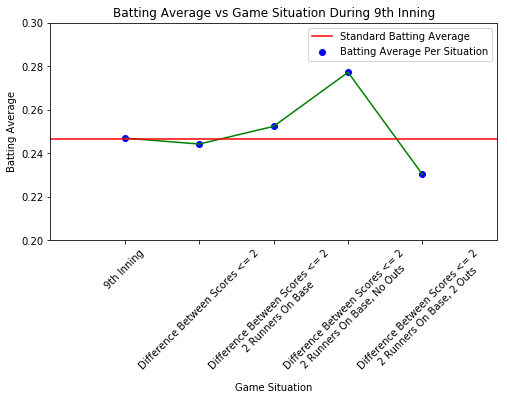

In [894]:
x = [ 1, 2, 3, 4, 5]
y = [nba, cba, trba, trnoba, trtoba]
lbs = ['9th Inning', 'Difference Between Scores <= 2', 'Difference Between Scores <= 2\n 2 Runners On Base','Difference Between Scores <= 2\n 2 Runners On Base, No Outs','Difference Between Scores <= 2\n 2 Runners On Base, 2 Outs']
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(x, y, 'g')
plt.plot([-1,7],[BA,BA],'r',label='Standard Batting Average')
plt.scatter(x, y, c='b', marker='o', label='Batting Average Per Situation')
ax.set_xlim(0,6)
ax.set_ylim(0.2, 0.3)
ax.set_ylabel('Batting Average')
ax.set_xlabel('Game Situation')
ax.set_title('Batting Average vs Game Situation During 9th Inning')
plt.xticks(x, lbs, fontsize=10, rotation=45)
ax.legend()
plt.show()

#### Batting Average vs Difference In Scores

In [925]:
#slicing on difference score differences
diffs = {
    -30:0,-29:0,-28:0,-27:0,-26:0,-25:0, -24:0, -23:0, -22:0, -21:0,
    -20:0,-19:0,-18:0,-17:0,-16:0,-15:0,-14:0,-13:0,-12:0,-11:0,
    -10:0, -9:0, -8:0, -7:0, -6:0, -5:0, -4:0, -3:0, -2:0, -1:0,
    0:0, 1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,
    11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,
    22:0,23:0,24:0,25:0,26:0,27:0,28:0,29:0,30:0
}
for key in diffs:
    print("Finding BA for score difference {0}...".format(key))
    diffs[key] = batting_average_loc(reduced,'diff',key)

Finding BA for score difference -30...
Finding BA for score difference -29...
Finding BA for score difference -28...
Finding BA for score difference -27...
Finding BA for score difference -26...
Finding BA for score difference -25...
Finding BA for score difference -24...
Finding BA for score difference -23...
Finding BA for score difference -22...
Finding BA for score difference -21...
Finding BA for score difference -20...
Finding BA for score difference -19...
Finding BA for score difference -18...
Finding BA for score difference -17...
Finding BA for score difference -16...
Finding BA for score difference -15...
Finding BA for score difference -14...
Finding BA for score difference -13...
Finding BA for score difference -12...
Finding BA for score difference -11...
Finding BA for score difference -10...
Finding BA for score difference -9...
Finding BA for score difference -8...
Finding BA for score difference -7...
Finding BA for score difference -6...
Finding BA for score differen

In [928]:
#getting the actual means and hyp testing
diffbas = []
stds = []
ns = []
tests = []
ps = []
z = 1.96
a = 0.05
frames = []

#buncha p tests
for key in diffs:
    #empty frame
    try:
        if(diffs[key]==-1):
            continue
    except:
        1==1
    m = diffs[key]['BA'].mean()
    s = diffs[key]['BA'].var()
    n = diffs[key].shape[0]
    t = (m - BA)/(((s**2 / n)+(BAs**2 / BAn))**0.5)
    p = stats.t.cdf(-abs(t), n-1)
    
    diffbas.append(m)
    stds.append(s)
    ns.append(n)
    tests.append(t)
    ps.append(p)
    
    frames.append(diffs[key])
    
    if(p<a):
        print("Null Hypothesis {0:.5} rejected with mean {1:.5} and T value {2:.5} for diff {3}".format(BA, m, p, key))
    else:
        print("Failed To Reject Null Hypothesis {0:.5} with mean {1:.5} and P value {2:.5}".format(BA, m, p))

##
wut = pd.concat(frames)
print(wut.BA.mean())
print(std_bt_average.BA.mean())

Null Hypothesis 0.24655 rejected with mean 0.0 and T value 2.1443e-07 for diff -27
Failed To Reject Null Hypothesis 0.24655 with mean 0.5 and P value 0.11284
Failed To Reject Null Hypothesis 0.24655 with mean 0.0 and P value nan
Null Hypothesis 0.24655 rejected with mean 0.0 and T value 1.143e-15 for diff -23
Failed To Reject Null Hypothesis 0.24655 with mean 0.28261 and P value 0.12208
Null Hypothesis 0.24655 rejected with mean 0.19388 and T value 0.010441 for diff -21
Failed To Reject Null Hypothesis 0.24655 with mean 0.24638 and P value 0.49689
Null Hypothesis 0.24655 rejected with mean 0.21176 and T value 0.0024474 for diff -19
Null Hypothesis 0.24655 rejected with mean 0.29075 and T value 0.00052213 for diff -18
Null Hypothesis 0.24655 rejected with mean 0.27342 and T value 0.0034532 for diff -17
Null Hypothesis 0.24655 rejected with mean 0.25818 and T value 0.037921 for diff -16
Null Hypothesis 0.24655 rejected with mean 0.2631 and T value 0.00078858 for diff -15
Null Hypothesis 

C:\Users\Vail Dorchester\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Vail Dorchester\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Vail Dorchester\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Null Hypothesis 0.24655 rejected with mean 0.26602 and T value 0.0 for diff 0
Null Hypothesis 0.24655 rejected with mean 0.26494 and T value 0.0 for diff 1
Null Hypothesis 0.24655 rejected with mean 0.26681 and T value 0.0 for diff 2
Null Hypothesis 0.24655 rejected with mean 0.2681 and T value 0.0 for diff 3
Null Hypothesis 0.24655 rejected with mean 0.26955 and T value 0.0 for diff 4
Null Hypothesis 0.24655 rejected with mean 0.2651 and T value 0.0 for diff 5
Null Hypothesis 0.24655 rejected with mean 0.26585 and T value 2.2502e-265 for diff 6
Null Hypothesis 0.24655 rejected with mean 0.26611 and T value 4.4148e-176 for diff 7
Null Hypothesis 0.24655 rejected with mean 0.26693 and T value 3.0485e-122 for diff 8
Null Hypothesis 0.24655 rejected with mean 0.27096 and T value 3.7507e-108 for diff 9
Null Hypothesis 0.24655 rejected with mean 0.26479 and T value 2.256e-39 for diff 10
Null Hypothesis 0.24655 rejected with mean 0.25862 and T value 3.0575e-12 for diff 11
Null Hypothesis 0.2

In [935]:
zero1 = batting_average_loc(reduced)
z1 = reduced.loc[reduced['diff']==0]
zero = batting_average_loc(z1)


In [936]:
print(zero['BA'].mean())
print(zero1['BA'].mean())

0.26601920033308313
0.24654756217419604


#### Batting Average vs Number of Outs

#### Batting average vs inning

In [898]:
ba_in = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for key in ba_in:
    print("Finding BA for inning {0}...".format(key))
    ba_in[key] = batting_average_loc(events,'inning',key)

Finding BA for inning 1...
Finding BA for inning 2...
Finding BA for inning 3...
Finding BA for inning 4...
Finding BA for inning 5...
Finding BA for inning 6...
Finding BA for inning 7...
Finding BA for inning 8...
Finding BA for inning 9...


##### Hypothesis Testing

In [899]:
bain = []
for key in ba_in:
    bain.append(ba_in[key].BA.mean())
    print(ba_in[key].BA.std())
    hyp_test(ba_in[key],'BA',ba)

0.4418337527997428
Null rejected with z: 38.31
Sample Mean: 0.2664
Null Mean: 0.2496


0.4323918395808407
Null not rejected with z: -0.4347
Sample Mean: 0.2494
Null Mean: 0.2496


0.4374758400962926
Null rejected with z: 20.36
Sample Mean: 0.2585
Null Mean: 0.2496


0.4407098558449838
Null rejected with z: 33.82
Sample Mean: 0.2644
Null Mean: 0.2496


0.4390065501216805
Null rejected with z: 26.68
Sample Mean: 0.2613
Null Mean: 0.2496


0.44032495506896335
Null rejected with z: 32.3
Sample Mean: 0.2638
Null Mean: 0.2496


0.4377107722124046
Null rejected with z: 21.16
Sample Mean: 0.2589
Null Mean: 0.2496


0.4351737795673469
Null rejected with z: 10.68
Sample Mean: 0.2543
Null Mean: 0.2496


0.4310200855704479
Null rejected with z: -5.48
Sample Mean: 0.2469
Null Mean: 0.2496




Y = -0.00106x + 0.264


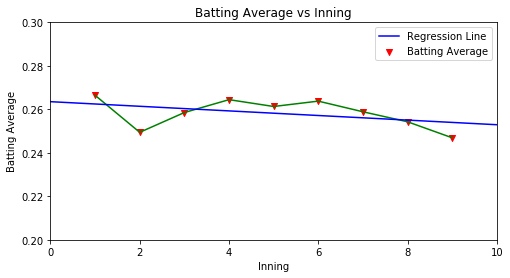

In [900]:
x = list(ba_in.keys())
y = bain
x_avg = np.sum(x)/9
y_avg = np.sum(y)/9
beta = np.sum((x - x_avg)*(y - y_avg))/np.sum((x - x_avg)**2)
alpha = y_avg - beta*x_avg
x_int = -alpha/ beta
print("Y = {0:.3}x + {1:.3}".format(beta, alpha))
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(x, y, 'g')
plt.plot([0, x_int], [alpha, 0], 'b', label='Regression Line')
plt.scatter(x, y, c='r', marker='v', label='Batting Average')
ax.set_xlim(0,10)
ax.set_ylim(0.2, 0.3)
ax.set_ylabel('Batting Average')
ax.set_xlabel('Inning')
ax.set_title('Batting Average vs Inning')
ax.legend()
plt.show()

In [809]:
gameavg = std_bt_average.groupby('game id')['BA'].agg(np.mean)
gameavg.head()

game id
BOS195004180    0.322000
BOS195004192    0.314493
BOS195004280    0.263889
BOS195004301    0.270833
BOS195004302    0.282540
Name: BA, dtype: float64

#### Seeing which weather factors effect BA and by how much

In [363]:
weather = gl2data[get]
print(weather.shape)
print(gameavg.shape)
weather.head()
ga = pd.DataFrame()
ga['game id'] = gameavg.keys()
ga['BA'] = gameavg.reset_index()['BA']
ga.head()
weather = weather.merge(ga, left_on='game id', right_on='game id', how='inner')
#weather.drop(['BA_x'], axis=1)
weather.rename(columns={'BA_y': 'BA'}, inplace=True)
weather.head()

cols = weather.columns
weather[cols] = weather[cols].replace({'0':np.nan, 0:np.nan})
weather[cols] = weather[cols].replace({'-1':np.nan, -1:np.nan})

weather['day/night flag'] = weather['day/night flag'].astype('category')#cast to category
#convert categories to ints
cat_cols = weather.select_dtypes(['category']).columns #get cat cols
weather[cat_cols] = weather[cat_cols].apply(lambda x: x.cat.codes) #to int
weather.head()

(66801, 9)
(126746,)


,game id,day/night flag,attendance,temperature,wind direction,wind speed,field condition,precipitation,sky,BA
0,BOS195004180,0,31822.0,NaN,NaN,NaN,NaN,NaN,NaN,0.322000
1,BOS195004192,0,32860.0,NaN,NaN,NaN,NaN,NaN,NaN,0.314493
2,BOS195004280,0,5333.0,NaN,NaN,NaN,NaN,NaN,NaN,0.263889
3,BOS195004301,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.270833
4,BOS195004302,0,34697.0,NaN,NaN,NaN,NaN,NaN,NaN,0.282540


In [371]:
rw = weather.dropna()
y = rw.BA
x = rw.drop(['BA', 'game id'], axis=1)
trainx, testx, trainy, testy = train_test_split(x, y, random_state=0)

In [424]:
forest = RandomForestRegressor(max_leaf_nodes=10)
forest.fit(trainx, trainy)
feature_importance = forest.feature_importances_
indices = np.argsort(feature_importance)[::-1]

#convert the x data to proper data frame
trainx_df = pd.DataFrame(data=trainx)#make it a dataframe
trainx_df.columns = x.columns#name the columns
testx_df = pd.DataFrame(data=testx)#make it a dataframe
testx_df.columns = x.columns#name the columns

trainx_df.iloc[indices].columns[:10]

important_cols = trainx_df.iloc[indices].columns #these are the important columns
#gonna put those columns in a dictionary to hold each of their correlations with sale price
feature_corr_dict = dict((key, 0) for key in important_cols) #key is each value in important cols, value is 0 by default
for feature in feature_corr_dict: #iterate and calc corr coef for each feature
    corr = np.corrcoef(trainx_df[feature], trainy) #correlation matrix
    feature_corr_dict[feature]=corr[1,0] #correlation of x,y 
f_corr = pd.Series(data=feature_corr_dict) #create series from data
f_corr = f_corr.sort_values(ascending=False)
f_corr = f_corr.dropna()
f_corr

temperature        0.085970
precipitation      0.024802
wind direction     0.021322
attendance         0.017018
day/night flag     0.009281
wind speed         0.006130
sky                0.002387
field condition   -0.032454
dtype: float64

In [425]:
f_corr = f_corr.reset_index()

In [426]:
f_corr.iloc[:,1]
f_corr.columns

Index(['index', 0], dtype='object')

['temperature', 'precipitation', 'wind direction', 'attendance', 'day/night flag', 'wind speed', 'sky', 'field condition']


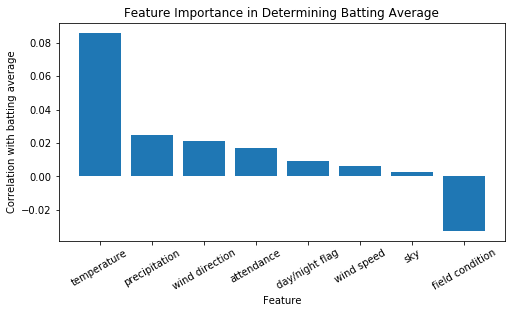

In [427]:
lbs = f_corr.iloc[:,0].tolist()
ys = f_corr.iloc[:,1]
ixx = np.arange(f_corr.shape[0])
print(lbs)
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(ixx,ys)
plt.xticks(ixx, lbs, fontsize=10, rotation=30)
ax.set_title("Feature Importance in Determining Batting Average")
ax.set_ylabel('Correlation with batting average')
ax.set_xlabel('Feature')
plt.show()

In [428]:
predictions = forest.predict(testx)
print("Mean Absolute Error: {0:.8}".format(mean_absolute_error(predictions, testy)))


Mean Absolute Error: 0.048708828
